In [6]:
using Revise
includet("../../../scripts/competing_mms.jl")

In [7]:
using GLMakie
using CairoMakie
CairoMakie.activate!()

In [8]:
using JLD2

In [13]:
f1 = jldopen("../../../cluster_env/runs/compmm_sines1/rslts2.jld2")
f2 = jldopen("../../../cluster_env/runs/compmm_sines1/rslts3.jld2")

JLDFile /home/honza/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode/cluster_env/runs/compmm_sines1/rslts3.jld2 (read-only)
 ├─🔢 Ks
 └─🔢 results

# PG 2 - looking at a cluster run

In [41]:
f = jldopen("../../../cluster_env/runs/compmm_sines1/rslts4_m_c_0.5.jld2")
Ks = f["Ks"]
num_repeats = length(f["results"][1].outcomes)
nothing

In [42]:
out_cms = map(f["results"]) do x
    countmap(x.outcomes)
end

num_ext = []
num_coex = []
num_S1 = []
num_S2 = []
for cm in out_cms
    push!(num_ext, get(cm, CMMsSpatialOutcome.Extinction, 0))
    push!(num_coex, get(cm, CMMsSpatialOutcome.Coexistence, 0))
    push!(num_S1, get(cm, CMMsSpatialOutcome.S1Only, 0))
    push!(num_S2, get(cm, CMMsSpatialOutcome.S2Only, 0))
end
@assert all((num_ext .+ num_coex .+ num_S1 .+ num_S2) .== num_repeats)

## Diversity outcome

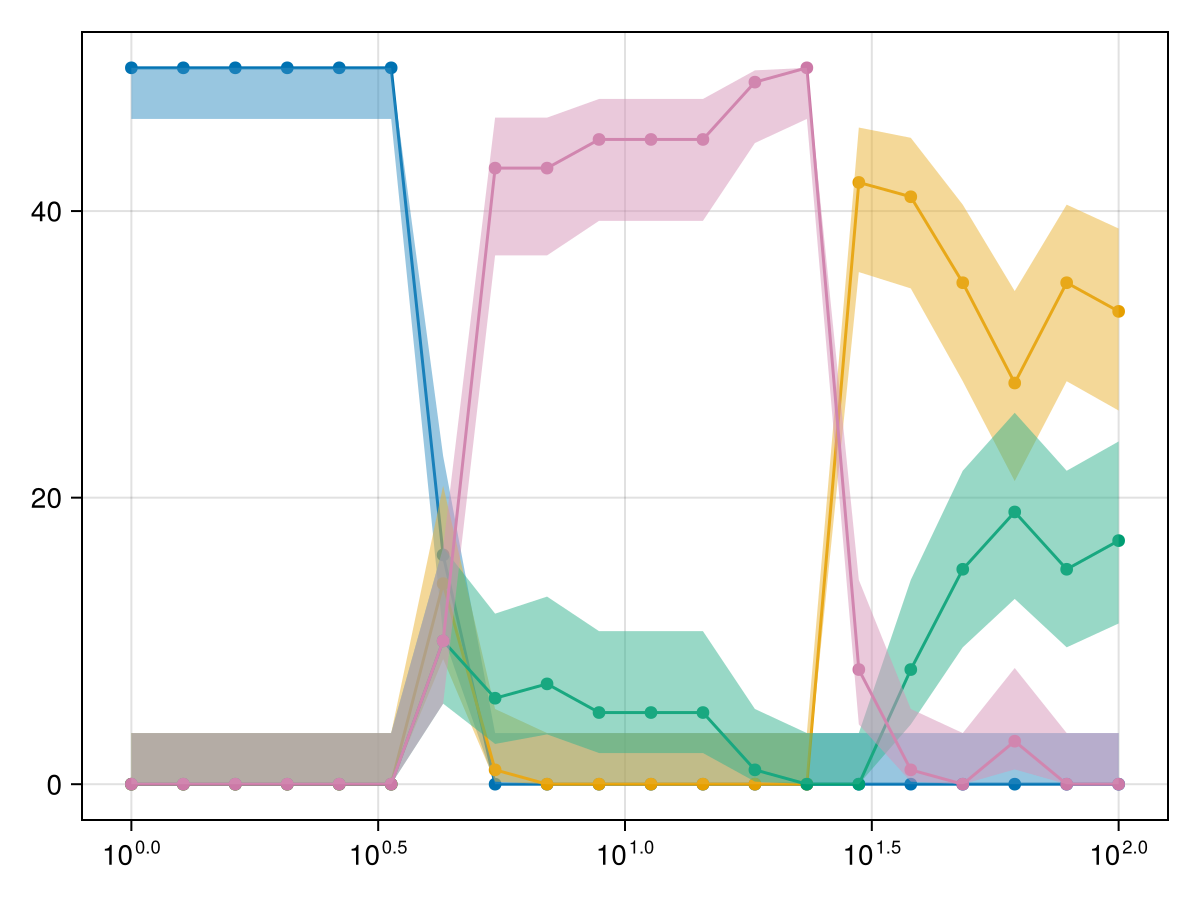

In [44]:
fig = Figure()
ax = Axis(fig[1,1];
    xscale=log10,
)

plot_binom_sample!(ax, Ks, num_ext, num_repeats)
plot_binom_sample!(ax, Ks, num_S1, num_repeats)
plot_binom_sample!(ax, Ks, num_S2, num_repeats)
plot_binom_sample!(ax, Ks, num_coex, num_repeats)

fig

## Spatial structure?

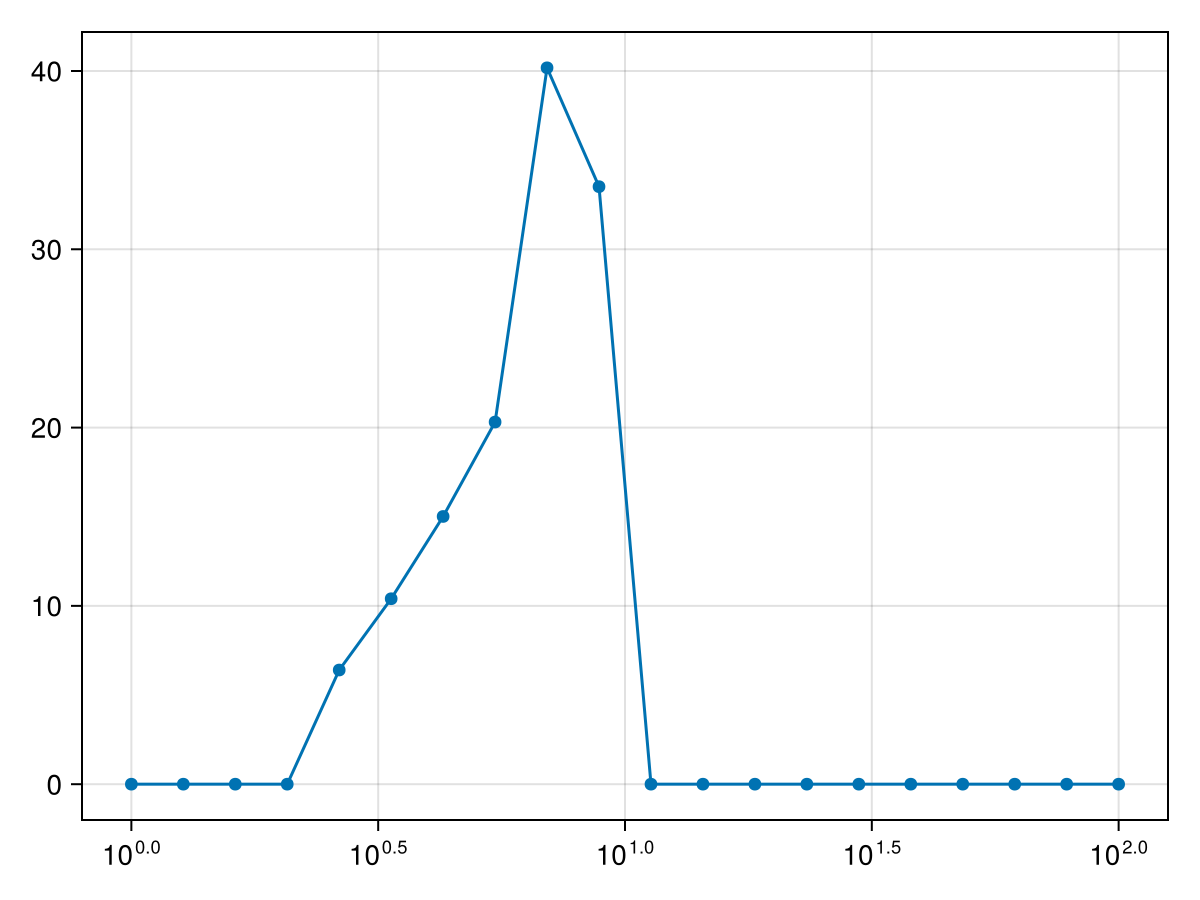

In [40]:
ii = 1
ii_stds = map(f["results"]) do x
    map(x.fss) do fs
        std(@view fs[ii,:])
    end
end
xx = map(mean, ii_stds)
scatterlines(Ks, xx; axis=(; xscale=log10))

In [20]:
xx = f["results"][1].fss[1]
std(xx; dims=2) ./ mean(xx; dims=2)

5×1 Matrix{Float64}:
 -1.025942120512162
 -0.9353328404486778
  1.5830176777266256e-10
 -0.5170580396402188
 -0.458002928248931

## The first, messy run

In [5]:
outcomes = load_object("../../../cluster_env/runs/compmm_sines1/r1_outcomes_only.jld2");
mfss = load_object("../../../cluster_env/runs/compmm_sines1/r1_fss_only.jld2");

In [9]:
map(countmap, outcomes)

20-element Vector{Dict{Any, Int64}}:
 Dict(Main.CMMsSpatialOutcome.Extinction => 50)
 Dict(Main.CMMsSpatialOutcome.Extinction => 50)
 Dict(Main.CMMsSpatialOutcome.Extinction => 50)
 Dict(Main.CMMsSpatialOutcome.Extinction => 50)
 Dict(Main.CMMsSpatialOutcome.Extinction => 50)
 Dict(Main.CMMsSpatialOutcome.Extinction => 50)
 Dict(Main.CMMsSpatialOutcome.S2Only => 50)
 Dict(Main.CMMsSpatialOutcome.S2Only => 50)
 Dict(Main.CMMsSpatialOutcome.S2Only => 50)
 Dict(Main.CMMsSpatialOutcome.S2Only => 50)
 Dict(Main.CMMsSpatialOutcome.S2Only => 50)
 Dict(Main.CMMsSpatialOutcome.S2Only => 50)
 Dict(Main.CMMsSpatialOutcome.S2Only => 50)
 Dict(Main.CMMsSpatialOutcome.S2Only => 50)
 Dict(Main.CMMsSpatialOutcome.S2Only => 50)
 Dict(Main.CMMsSpatialOutcome.S2Only => 50)
 Dict(Main.CMMsSpatialOutcome.S2Only => 50)
 Dict(Main.CMMsSpatialOutcome.S2Only => 50)
 Dict(Main.CMMsSpatialOutcome.S2Only => 50)
 Dict(Main.CMMsSpatialOutcome.S2Only => 50)

# PG 1

In [174]:
mmp = MMParams(; K=8e2, m=1., c=1., l=1., d=1.)
@show get_simplified_analysis(mmp)
xx = analyse_mmp(mmp)

get_simplified_analysis(mmp) = :stable


2-element Vector{SSMCMain.ModifiedMiCRM.MinimalModelV2.NospaceSolStability.T}:
 NospaceSolStability.stable = 1
 NospaceSolStability.nospace_unstable = 0

In [89]:
typeof(xx)

Vector{T} (alias for Array{SSMCMain.ModifiedMiCRM.MinimalModelV2.NospaceSolStability.T, 1})

In [115]:
get_simplified_analysis(mmp)

:unstable

In [10]:
cmmsp = CMMsParams(;
    K=10.,
    m1=0.9, c1=0.9, l1=1.0,
    m2=1.0, c2=1.0, l2=1.0,
)
Ds = (;
    DN1=1e-6, DN2=1e-6,
    DI=1.,
    DR1=1., DR2=1.,
)
@show cmmsp_get_single_mm_results(cmmsp, Ds...)

cmmsp_get_single_mm_results(cmmsp, Ds...) = (:unstable, :unstable)


(:unstable, :unstable)

In [18]:
@time xx = run_siny_cmms(
    cmmsp,
    6, 1e8,
    5, 1000,
    1.0, 100, 50.0;
    Ds=SA[Ds...],
    run_threads=3,
)
countmap(xx.outcomes)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


  8.535445 seconds (6.41 M allocations: 4.781 GiB, 1.62% gc time)


Dict{Main.CMMsSpatialOutcome.T, Int64} with 1 entry:
  Coexistence => 6

In [14]:
countmap(xx.outcomes)

Dict{Main.CMMsSpatialOutcome.T, Int64} with 1 entry:
  Coexistence => 2

# PG 3

In [ ]:
Ks = [1., 2., 5., 10., 20.]

fig = Figure(;
    size=(600, 400*length(Ks))
)
prog = Progress(length(Ks))
@time for i in 1:length(Ks)
    K = Ks[i]
    gl = GridLayout(fig[i,1])
    fafa(
        K,
        0.9, 0.9,
        1., 1.;
        place=gl
    )
    next!(prog)
end
finish!(prog)

fig

In [273]:
using SSMCMain.ModifiedMiCRM.MinimalModelV2

In [314]:
analyse_mmp(
    MMParams(;
        K=4.,
        m=1.,
        c=1.,
        l=1.,
    )
)

1-element Vector{Any}:
 NospaceSolStability.unstable = 2

In [176]:
function find_min_deltaN0(
    K, m1, c1, m2, c2, N0mean, maxnumruns;
    tols=1e-8
)
    # require that the first strain is the objectively better one at ss
    @assert (m1 / c1) <= (m2 / c2)
    
    ps = make_comp_mms_params(K, m1, m2, 1., 1., c1, c2)

    req_deltaN0 = missing
    for deltaN0 in range(0., 2 * N0mean, maxnumruns)
        N1 = N0mean - deltaN0/2
        N2 = N0mean + deltaN0/2
        p = make_mmicrm_problem(ps, [N1, N2, 0., 0., 0.], T)
        s = solve(p, QNDF();
            abstol=tol, reltol=tol,
        )
        if s.u[end][2] > s.u[end][1]
            req_deltaN0 = deltaN0
            break
        end
    end
    req_deltaN0
end

find_min_deltaN0 (generic function with 1 method)

In [191]:
find_min_deltaN0(10., 0.9, 0.9, 1., 1., 10., 10000)

0.9000900090009001

In [205]:
K = 10.
m1 = 0.9
c1 = 0.9
m2 = 1.
c2 = 1.
T = 1e3

N0mean = 2.
deltaN0s = range(-0.9*N0mean, 0.9*N0mean, 1000)

tol = 1e-8

@assert (m1 / c1) <= (m2 / c2)

ps = make_comp_mms_params(K, m1, m2, 1., 1., c1, c2)

sols = Vector{Any}(undef, length(deltaN0s))
winners = Vector{Int}(undef, length(deltaN0s))
@time @tasks for i in 1:length(deltaN0s)
    deltaN0 = deltaN0s[i]
    N1 = N0mean - deltaN0/2
    N2 = N0mean + deltaN0/2
    p = make_mmicrm_problem(ps, [N1, N2, 0., 0., 0.], T)
    s = solve(p, QNDF();
        abstol=tol, reltol=tol,
    )
    sols[i] = s
    winners[i] = if s.u[end][1] > s.u[end][2]
        1
    else
        2
    end
end

# f = plot_mmicrm_sol(s)
# # display(GLMakie.Screen(), f.figure)
# f

  0.617607 seconds (1.57 M allocations: 153.340 MiB, 49.60% compilation time)


In [5]:
chi(m, c, r, N) = (m / c) * ((r / (c * N)) + 1)

chi (generic function with 1 method)

In [102]:
function N2_0_crit(N1_0, m1, c1, m2, c2, r, alpha)
    ff = (c2 * m1) / (m2 * c1)
    (r / (alpha * c2)) / (ff * ((r / (c1 * alpha * N1_0) + 1)) - 1)
end

N2_0_crit (generic function with 1 method)

In [255]:
K = 8.
m1 = 0.9
c1 = 0.9
m2 = 1.
c2 = 1.2
T = 1e3

Ns = range(0.1, 5., 100)

tol = 1e-8

# @assert (m1 / c1) <= (m2 / c2)

ps = make_comp_mms_params(K, m1, m2, 1., 1., c1, c2)

winners = Matrix{Int}(undef, length(Ns), length(Ns))
N10s = Matrix{Float64}(undef, length(Ns), length(Ns))
N1ss = Matrix{Union{Missing,Float64}}(undef, length(Ns), length(Ns))
N1fs = Matrix{Float64}(undef, length(Ns), length(Ns))
N20s = Matrix{Float64}(undef, length(Ns), length(Ns))
N2ss = Matrix{Union{Missing,Float64}}(undef, length(Ns), length(Ns))
N2fs = Matrix{Float64}(undef, length(Ns), length(Ns))
sTs = Matrix{Union{Missing,Float64}}(undef, length(Ns), length(Ns))
@time @tasks for i in 1:length(Ns)
    for j in 1:length(Ns)
        N1 = Ns[i]
        N2 = Ns[j]
    
        if N1 <= 0.
            winners[i,j] = 2
            continue
        elseif N2 <= 0.
            winners[i,j] = 1
            continue
        end
        
        
        p = make_mmicrm_problem(ps, [N1, N2, 0., 0., 0.], T)
        s = solve(p, QNDF();
            abstol=tol, reltol=tol,
        )
        
        winners[i,j] = if (s.u[end][1] + s.u[end][2]) < 1e-9
            0
        elseif s.u[end][1] > s.u[end][2]
            1
        else
            2
        end
        
        N10s[i,j] = N1
        N20s[i,j] = N2
        N1fs[i,j] = s.u[end][1]
        N2fs[i,j] = s.u[end][2]

        ii = find_selection_frame(s;
            threshold=1e-6,
            fail_if_extinct=false,
        )
        if isnothing(ii)
            N1ss[i,j] = missing
            N2ss[i,j] = missing
            sTs[i,j] = missing
        else
            # @show length(s.u)-ii
            us = s.u[ii]
            N1ss[i,j] = us[1]
            N2ss[i,j] = us[2]
            sTs[i,j] = s.t[ii]
        end
    end
end

chi1s = [(m1/c1)*((1.0/(c1*N))+1) for N in N1ss]
chi2s = [(m2/c2)*((1.0/(c2*N))+1) for N in N2ss]
bchi1s = [(m1/c1)*((1.0/(c1*N))+1) for N in N10s]
bchi2s = [(m2/c2)*((1.0/(c2*N))+1) for N in N20s];

  5.853182 seconds (13.78 M allocations: 1.358 GiB, 17.76% compilation time)


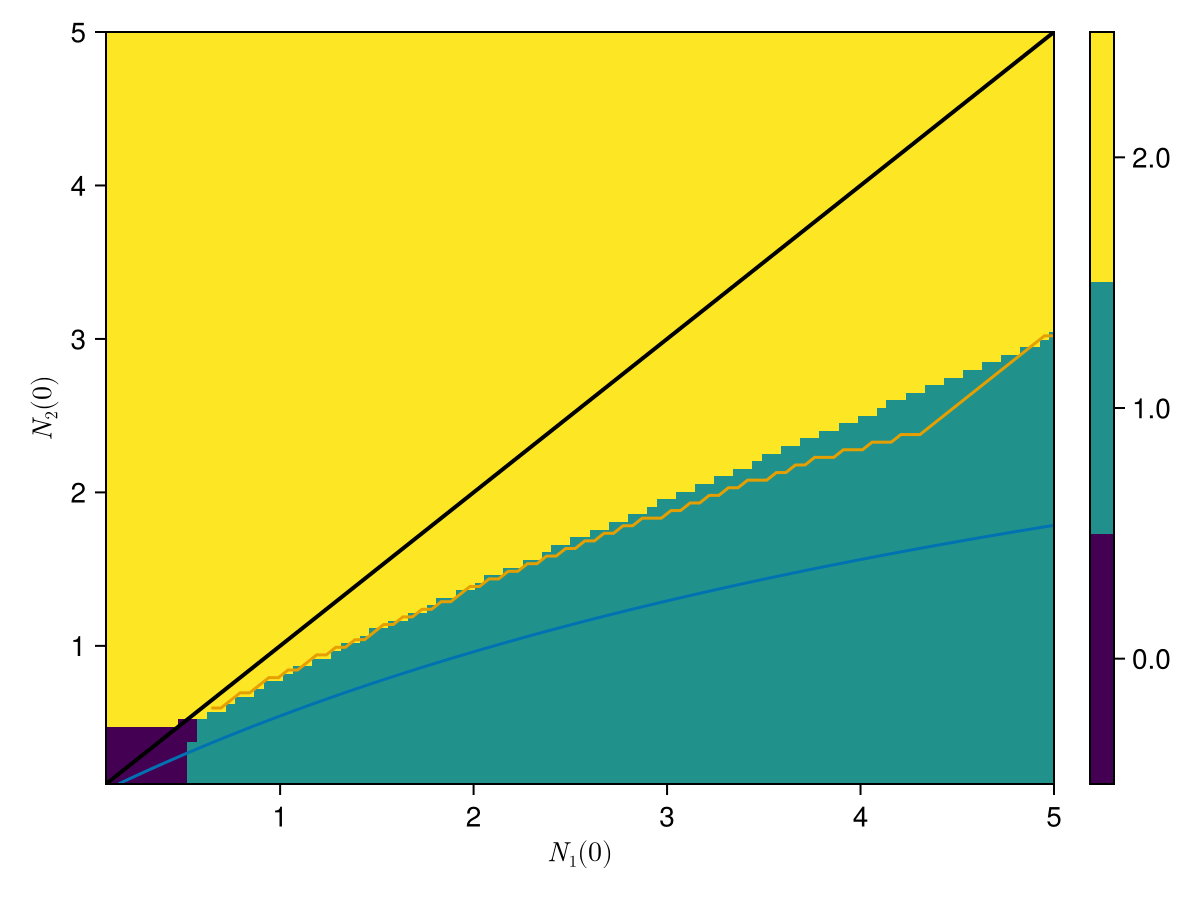

In [256]:
fap = heatmap(Ns, Ns, winners;
    axis=(;
        xlabel=L"N_1(0)",
        ylabel=L"N_2(0)",
    ),
    colormap=Categorical(:viridis),
)
Colorbar(fap.figure[1,2], fap.plot)

mn = minimum(Ns)
mx = maximum(Ns)
lines!(fap.axis, [mn, mx], [mn, mx]; color=:black, linewidth=2)

# Draw N0 prediction line
xx = N2_0_crit.(Ns, m1, c1, m2, c2, 1., 1.)
lines!(fap.axis, Ns, xx)

# Draw actual Ns prediction line
yy1 = []
yy2 = []
for i in 1:length(Ns)
    for j in 1:length(Ns)
        chi1 = chi1s[i,j]
        chi2 = chi2s[i,j]
        if !ismissing(chi1) && !ismissing(chi2) && chi2 < chi1
            push!(yy1, Ns[i])
            push!(yy2, Ns[j])
            break
        end
    end
end
lines!(fap.axis, yy1, yy2)

#

xlims!(fap.axis, extrema(Ns)...)
ylims!(fap.axis, extrema(Ns)...)

fap

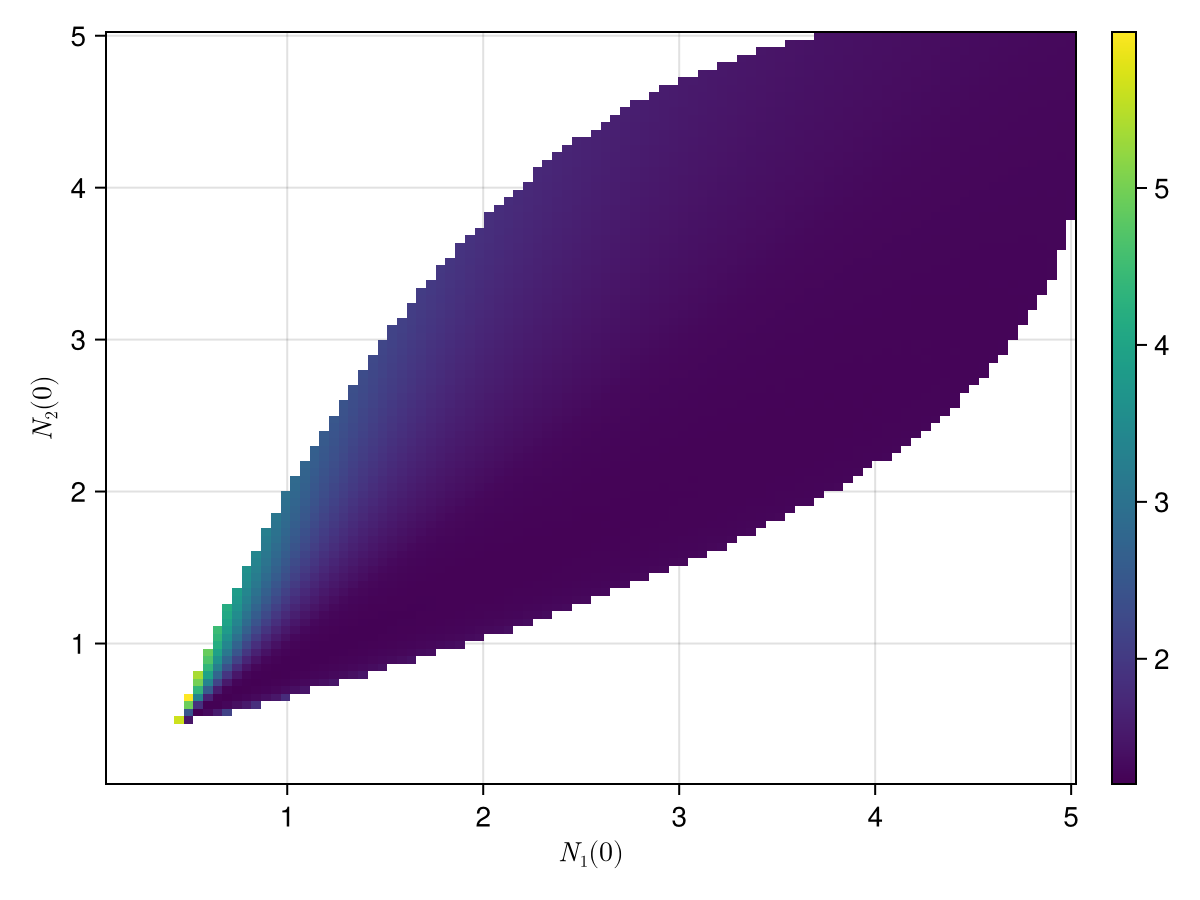

In [237]:
fap = heatmap(Ns, Ns, chi1s;
    axis=(;
        xlabel=L"N_1(0)",
        ylabel=L"N_2(0)",
    ),
    # colormap=Categorical(:viridis),
)
Colorbar(fap.figure[1,2], fap.plot)

fap

In [227]:
w1 = chi1s .< chi2s
bw1 = bchi1s .< bchi2s
aw1 = winners .== 1;

In [233]:
countmap(zip(w1, aw1))

Dict{Tuple{Union{Missing, Bool}, Bool}, Int64} with 5 entries:
  (false, 0)   => 2190
  (missing, 0) => 2759
  (true, 1)    => 2126
  (false, 1)   => 166
  (missing, 1) => 2759

In [72]:
K = 10.
m1 = 0.9
c1 = 0.9
m2 = 1.
c2 = 1.
T = 1e3

meanN0s = range(0.1, 10., 100)
deltaN0s = range(-1., 1., 100)

tol = 1e-8

@assert (m1 / c1) <= (m2 / c2)

ps = make_comp_mms_params(K, m1, m2, 1., 1., c1, c2)

winners = Matrix{Int}(undef, length(meanN0s), length(deltaN0s))
N10s = Matrix{Float64}(undef, length(meanN0s), length(deltaN0s))
N1ss = Matrix{Float64}(undef, length(meanN0s), length(deltaN0s))
N1fs = Matrix{Float64}(undef, length(meanN0s), length(deltaN0s))
N20s = Matrix{Float64}(undef, length(meanN0s), length(deltaN0s))
N2ss = Matrix{Float64}(undef, length(meanN0s), length(deltaN0s))
N2fs = Matrix{Float64}(undef, length(meanN0s), length(deltaN0s))
@time @tasks for i in 1:length(meanN0s)
    for j in 1:length(deltaN0s)
        meanN0 = meanN0s[i]
        deltaN0 = deltaN0s[j]
        N1 = meanN0 - deltaN0/2
        N2 = meanN0 + deltaN0/2
    
        if N1 <= 0.
            winners[i,j] = 2
            continue
        elseif N2 <= 0.
            winners[i,j] = 1
            continue
        end
        
        
        p = make_mmicrm_problem(ps, [N1, N2, 0., 0., 0.], T)
        s = solve(p, QNDF();
            abstol=tol, reltol=tol,
        )
        
        winners[i,j] = if (s.u[end][1] + s.u[end][2]) < 1e-9
            0
        elseif s.u[end][1] > s.u[end][2]
            1
        else
            2
        end

        if s.retcode != ReturnCode.Success
            @show s.retcode
        end

        N10s[i,j] = N1
        N20s[i,j] = N2
        N1fs[i,j] = s.u[end][1]
        N2fs[i,j] = s.u[end][2]

        ii = find_selection_frame(s; fail_if_extinct=false)
        if isnothing(ii)
            N1ss[i,j] = -1.
            N2ss[i,j] = -1.
        else
            us = s.u[ii]
            if !isfinite(us[1])
                @show us1 ii
            end
            N1ss[i,j] = us[1]
            N2ss[i,j] = us[2]
        end
    end
end

  8.240506 seconds (16.12 M allocations: 1.544 GiB, 8.19% compilation time)


In [50]:
chi1s = [(m1/c1)*((1.0/(c1*N))+1) for N in N1ss]
chi2s = [(m2/c2)*((1.0/(c2*N))+1) for N in N2ss];

In [74]:
sort(N1fs[:])

10000-element Vector{Float64}:
  -1.0975102679472922e305
  -1.0975102679472922e305
  -1.0975102679472922e305
  -1.0975102679472922e305
  -1.0975102679472922e305
  -1.0975102679472922e305
  -1.1183838967560826e-11
  -4.634377935186e-12
  -4.299266235579956e-12
  -3.9380230845661806e-12
  -2.2424515928741396e-12
  -2.1893405235004063e-12
  -1.8483142883115743e-12
   ⋮
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

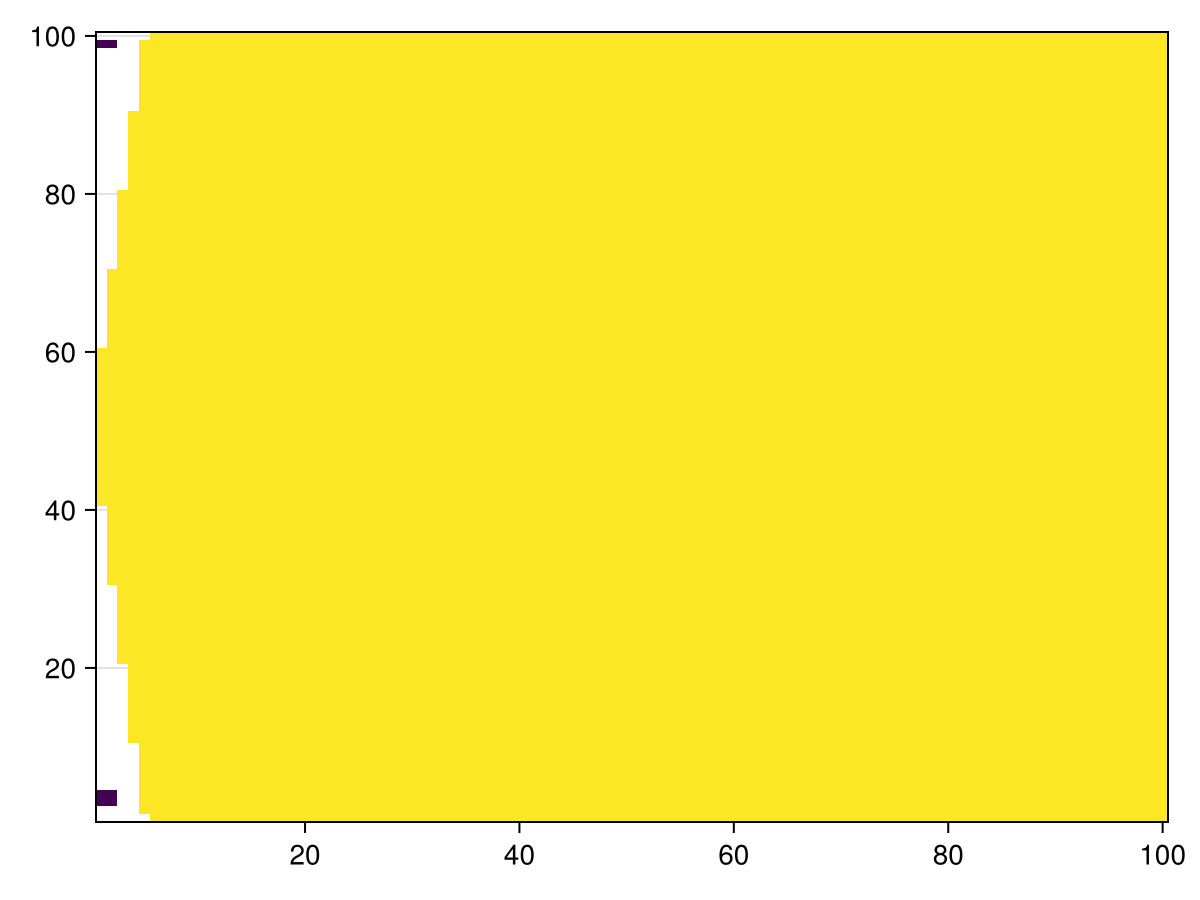

In [79]:
heatmap(N1fs)

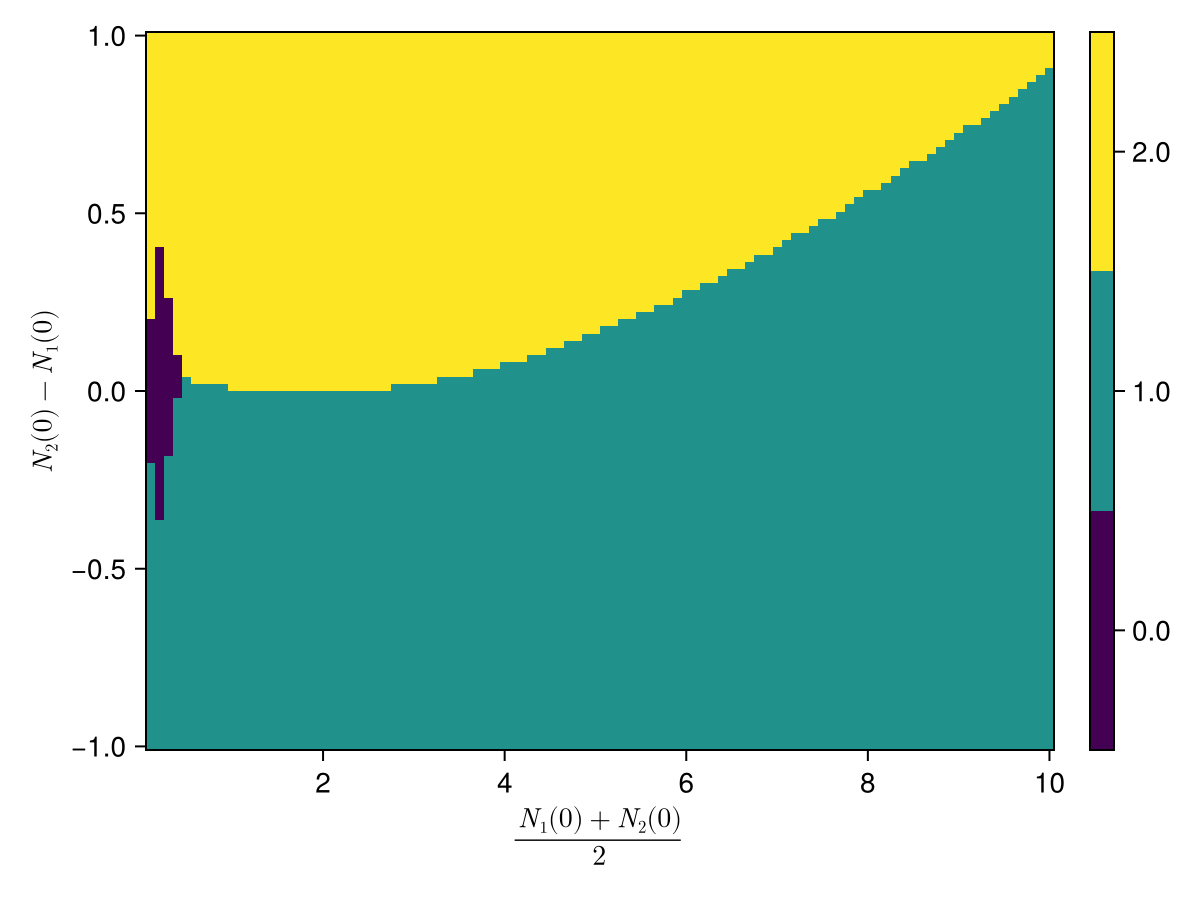

In [66]:
fap = heatmap(meanN0s, deltaN0s, winners;
    axis=(;
        xlabel=L"\frac{N_1(0)+N_2(0)}{2}",
        ylabel=L"N_2(0)-N_1(0)",
    ),
    colormap=Categorical(:viridis),
)
Colorbar(fap.figure[1,2], fap.plot)
fap

In [240]:
Makie.save("../../data/comp_mms/nospace_fates_m_c_0.9_2.pdf", fap)

CairoMakie.Screen{PDF}


# Run a Spatial Sim

In [46]:
cmmsp = CMMsParams(;
    K=10.,
    m1=0.9, c1=0.9, l1=1.,
    m2=1.0, c2=1.0, l2=1.,
)
ps = cmmsp_to_mmicrm(cmmsp)
Ds = SA[1e-6, 1e-6, 1., 1., 1.]

L = 30
sN = 10000
dx = L / sN

fu0 = get_2mm_u0_sines(sN, dx, 1., 10, 10);

In [47]:
sps = BSMMiCRMParams(
    ps,
    Ds,
    CartesianSpace{1,Tuple{Periodic}}(SA[dx]),
    nthreads()
)

p = make_smmicrm_problem(sps, fu0, 1e8)
tol = 1e-8
@time s = solve(p, QNDF();
    abstol=tol, reltol=tol,
);

315.852124 seconds (18.33 M allocations: 47.868 GiB, 17.37% gc time, 0.00% compilation time)


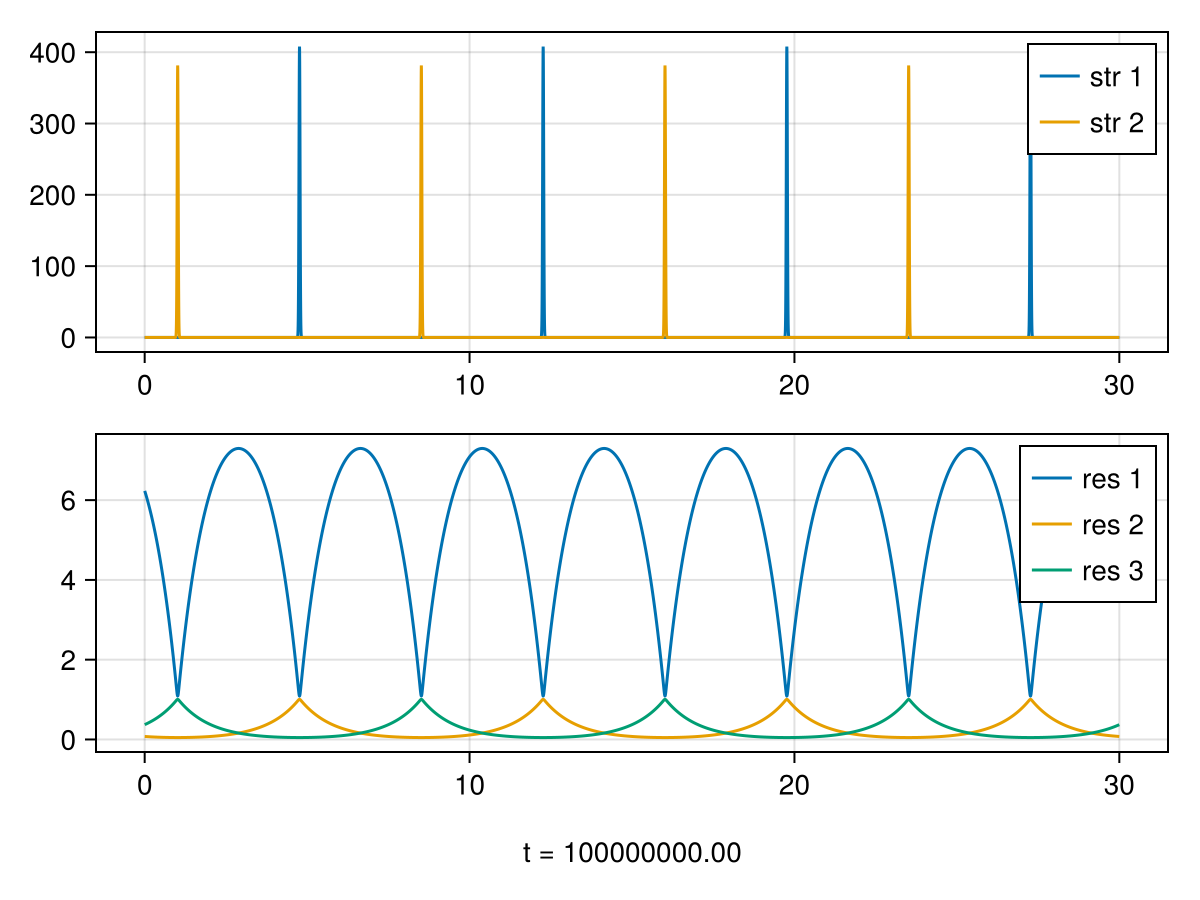

In [48]:
f = plot_1dsmmicrm_sol_snap(s, -1)

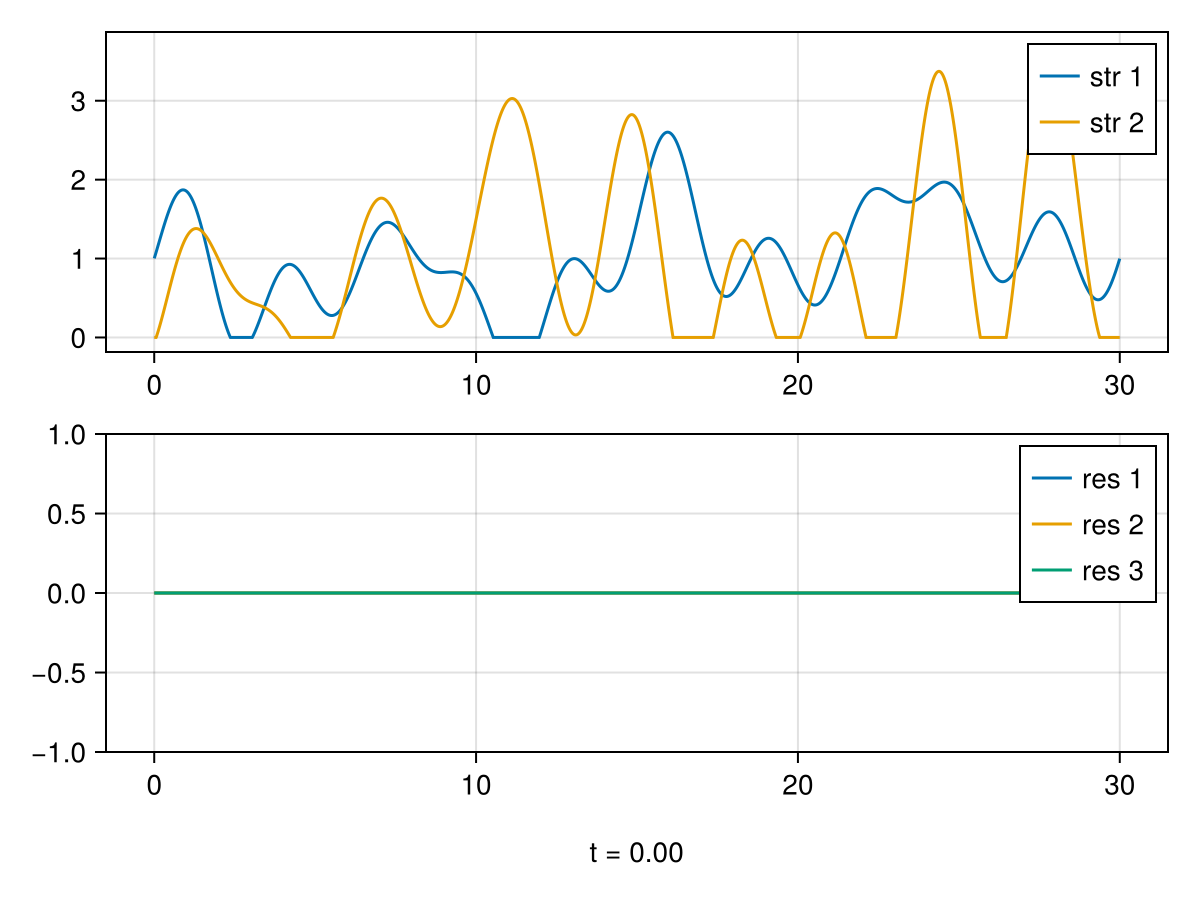

In [49]:
f = plot_1dsmmicrm_sol_snap(s, 1)

In [50]:
faa = plot_1dsmmicrm_sol_interactive(s)
display(GLMakie.Screen(), faa)
# faa

GLMakie.Screen(...)